In [4]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')


!pip install -Uqq fastai duckduckgo_search

#### Build an app to check whether a person is in a national park, and heck whether the photo is of a bird
### Previously would take years to build. Now it can be done in a few minutes

- Use duckduckgo to search for photos of birds
- Use duckduckgo to search for images of forests
- Fine-tune a pretrained neural network to recognize the two groups
- Try running this model on a picture of a bird and see if it works

# Step 1: Download images of birds and non-birds

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # L behaves like a list of items but can also index with a list of indicies
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

urls = search_images("bird photos", max_images=1)
urls[0]

Searching for 'bird photos'


'http://hdqwalls.com/download/1/colorful-parrot-bird.jpg'

In [6]:
# download the url
from fastdownload import download_url
dest = "bird.jpg"
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
#im = Image.open(dest)
#im.to_thumb(256, 256)

In [7]:
download_url(search_images("forest photos", max_images=1)[0], "forest.jpg", show_progress=False)
#Image.open("forest.jpg").to_thumb(256, 256)

Searching for 'forest photos'


Path('forest.jpg')

In [8]:
# save each group of bird and forest photos to a different folder
searches = "forest", "bird"
path = Path("bird_or_not")
from time import sleep

for searchTerm in searches:
    destination = (path/searchTerm)
    destination.mkdir(exist_ok=True, parents=True)
    download_images(destination, urls=search_images(f"{searchTerm} photo"))
    sleep(10)
    # Try other lighting conditions
    download_images(destination, urls=search_images(f"{searchTerm} sun photo"))
    sleep(10)
    download_images(destination, urls=search_images(f"{searchTerm} shade photo"))
    sleep(10)
    resize_images(path/searchTerm, max_size=400, destination=path/searchTerm)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [9]:
# remove failed to download images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

# Step 2: Train our model

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.948611,0.813634,0.272727,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.140643,0.171023,0.030303,00:43
1,0.086302,0.020165,0.000000,00:43
2,0.058523,0.004041,0.000000,00:44


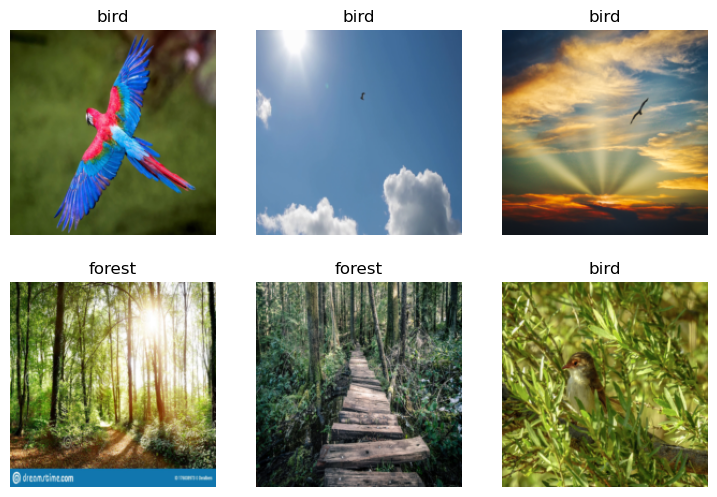

In [12]:
# To train a model we use DataLoaders which is an object that contains the training set
# and validation set
# In fastai we create this with a DataBlock

data_loaders = DataBlock(
    # inputs are images, outputs are categories
    blocks=(ImageBlock, CategoryBlock),
    # returns a list of all images files in the path
    get_items=get_image_files,
    # split the data into training and validation sets randomly. 20% of data used for validation
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # The labels (y values) is the name of the parent directory of each file
    get_y=parent_label,
    # before training resize each image by squishing (opposed to cropping)
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path, bs=32)

data_loaders.show_batch(max_n=6)

# Now we are ready to train. We will use resnet18 which is the fastest widely used computer vision model
# fastai comes with fine_tune() method which automatically uses best practices for fine tuning a pre trained model
learn = vision_learner(data_loaders, resnet18, metrics=error_rate)
learn.fine_tune(3)

# Fine tuning means we are starting with a model someone else has trained using another dataset (pretrained)
# and adjusting weights a little bit so that the model learns to use your particular set
# In this case the pre trained model was trained to recognize photos in imagenet, a widely used computer vision dataset with images covering 1000 categories

# Step 3: Use the model (and build your own!)

In [ ]:
# test model on bird we downloaded at the start
pil_image = PILImage.create("bird.jpg")
pil_image
learn.predict(pil_image)